In [252]:
sc

# Data Ingest

Here, the raw train data is read from csv flat file and saved as a more type-friendly parquet file

In [4]:
import csv
from dateutil import parser
from datetime import datetime
from pyspark.sql.types import *

sfcrime_raw_data = '/Users/bill.walrond/Documents/dsprj/data/SanFranCrime/train.csv'
sfcrime_schema_file = '/Users/bill.walrond/Documents/dsprj/data/SanFranCrime/train_schema.txt'

sfc_rdd = sc.textFile(sfcrime_raw_data)
    
print 'Line count of train file: %d' % sfc_rdd.count()

# Read and process the schema file
schemadict = {}
i = 0
schema = sc.textFile(sfcrime_schema_file)
line_cnt = schema.count()
print 'Lines in schema file: %d' % line_cnt
for l in schema.collect():
    col = l.split(',')
    schemadict.update({i: (col[0],col[1])})
    i += 1
print 'Length of the schemadict: %d' % len(schemadict.keys())

# Establish the Struct for the Schema
keys = schemadict.keys()
keys.sort()
schema = StructType()
for k in keys:
    if schemadict[k][1] == 'int':
        schema.add(StructField(schemadict[k][0], IntegerType(), True))
    elif schemadict[k][1] == 'str':
        schema.add(StructField(schemadict[k][0], StringType(), True))
    elif schemadict[k][1] == 'float':
        schema.add(StructField(schemadict[k][0], FloatType(), True))
    elif schemadict[k][1] == 'datetime':
        schema.add(StructField(schemadict[k][0], TimestampType(), True))
    else:
        print 'Unsupported or incorrect data type'

# Skip the first header line with this trick ...
sfc_nh = sfc_rdd.zipWithIndex().filter(lambda tup: tup[1] > 0).map(lambda tup: tup[0])

def toRowSep(line):
    """Parses one row using csv reader"""
    for r in csv.reader([line], delimiter=','):
        return r

sfc_split = sfc_nh.map(toRowSep)
    
lens = sfc_split.map(lambda r: len(r))
print 'Max len: %d' % lens.max()
print 'Min len: %d' % lens.min()
sfc_split.cache()

Line count of train file: 878050
Lines in schema file: 9
Length of the schemadict: 9
Max len: 9
Min len: 9


PythonRDD[9] at RDD at PythonRDD.scala:43

In [5]:
def convert_types(row,schema):
    d = row
    for col, data in enumerate(row):
        if col <= len(schema.keys()):
            typed = schema[col]
            if data is None:
                d[col] = None
            elif typed[1] == 'string':
                d[col] = data
            elif typed[1] == 'int':
                d[col] = int(round(float(data)))
            elif typed[1] == 'float':
                d[col] = float(data)
            elif typed[1] == 'datetime':
                # d[col] = data
                # d[col] = dateutil.parser.parse(data)
                d[col] = datetime.strptime(data,'%Y-%m-%d %H:%M:%S')
    return d

def toTypedRow(row):
    return convert_types(row, schemadict)

# Now, convert the types of all the rdd elements
sfc_typed = sfc_split.map(toTypedRow)
sfc_typed.take(1)
sfc_train = sqlContext.createDataFrame(sfc_typed, schema)
print sfc_train.count()

878049


In [ ]:
sfc_train = sfc_train.cache()
sfc_train.printSchema()

In [8]:
sfc_train.show(5)

+--------------------+--------------+--------------------+---------+----------+--------------+--------------------+-----------+---------+
|               Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|          X|        Y|
+--------------------+--------------+--------------------+---------+----------+--------------+--------------------+-----------+---------+
|2015-05-13 23:53:...|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST| -122.42589|37.774597|
|2015-05-13 23:53:...|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST| -122.42589|37.774597|
|2015-05-13 23:33:...|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...| -122.42436|37.800415|
|2015-05-13 23:30:...| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHERN|          NONE|1500 Block of LOM...|-122.426994|37.800873|
|2015-05-13 23:30:...| LARCENY/THE

In [19]:
parqFileName = '/Users/bill.walrond/Documents/dsprj/data/SanFranCrime/train.pqt'
sfc_train.write.parquet(parqFileName)

In [285]:
sc

# Data Profiling and Analysis

Next, the train data is injested from the parquet file and data profiling and analysis may begin

In [253]:
parqFileName = '/Users/bill.walrond/Documents/dsprj/data/SanFranCrime/train.pqt'
sfc_train = sqlContext.read.parquet(parqFileName)
print sfc_train.count()
print sfc_train.printSchema()
sfc_train = sfc_train.cache()

878049
root
 |-- Dates: timestamp (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: float (nullable = true)
 |-- Y: float (nullable = true)

None


In [254]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)


In [255]:
sfc_train = sfc_train.repartition(8)
print sfc_train.count()
sfc_train = sfc_train.cache()


878049


In [256]:
sfc_train.describe().show()


+-------+--------------------+------------------+
|summary|                   X|                 Y|
+-------+--------------------+------------------+
|  count|              878049|            878049|
|   mean| -122.42261639461971| 37.77102031342325|
| stddev|0.030353645185033078|0.4568931059287773|
|    min|          -122.51364|          37.70788|
|    max|              -120.5|              90.0|
+-------+--------------------+------------------+



### Profiling on the date-time column:  What do we want to know about a "datetime" column?

In [295]:
[name for name,type in sfc_train.dtypes if type == 'float' ]

['X', 'Y']

In [284]:
print 'Distinct date values: %d' % sfc_train.select("Dates").distinct().count()
print 'Earliest date:  %s ' % sfc_train.agg({"Dates": "min"}).collect()[0][0]
print 'Latest date: %s' % sfc_train.agg({"Dates": "max"}).collect()[0][0]

sfc_mod = sfc_train.select('*', trunc(sfc_train.Dates,'month').alias('yr-mo'))
sfc_mod = sfc_mod.cache()
sfc_month_grp = sfc_mod.groupBy('yr-mo').count()
sfc_month_grp = sfc_month_grp.cache()
print sfc_month_grp.orderBy('count', ascending=True).show(10)
earliest_mo = sfc_month_grp.agg(min('yr-mo')).collect()[0][0]
latest_mo = sfc_month_grp.agg(max('yr-mo')).collect()[0][0]
print 'Average obs per month: %d' % sfc_month_grp.agg(avg('count')).collect()[0][0]
print 'Earliest month: {0}\tLatest month: {1}'.format(earliest_mo, latest_mo)
print 'Time span:  {0}'.format(str(latest_mo-earliest_mo))
print 'Nulls: %d' % sfc_train.filter("Dates is Null").count()

Distinct date values: 389241
Earliest date:  2003-01-06 00:01:00 
Latest date: 2015-05-13 23:53:00
+----------+-----+
|     yr-mo|count|
+----------+-----+
|2015-05-01| 2250|
|2009-12-01| 4537|
|2009-06-01| 4543|
|2003-12-01| 4713|
|2008-12-01| 4736|
|2010-04-01| 4890|
|2004-12-01| 4944|
|2009-07-01| 4960|
|2010-03-01| 4997|
|2004-11-01| 5011|
+----------+-----+
only showing top 10 rows

None
Average obs per month: 5892
Earliest month: 2003-01-01	Latest month: 2015-05-01
Time span:  4503 days, 0:00:00
Nulls: 0


### What do we want to know about a "str" column?

- number of nulls (% nulls)
- number of unique values (categories)
- Category count
- Simple bar plot of the Top 20 Category Counts
- Does it look like free-form text?
- Min/max/avg length
- Avg word count
- Avg word length
- language

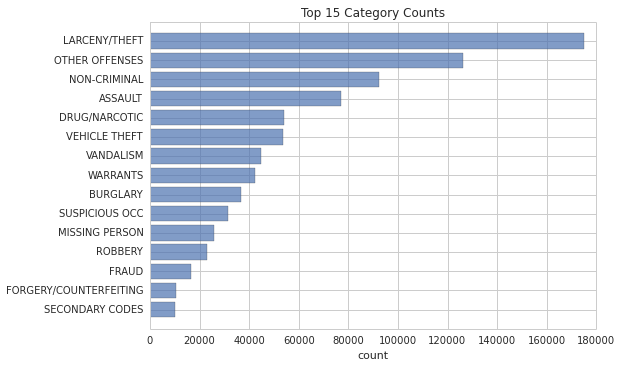

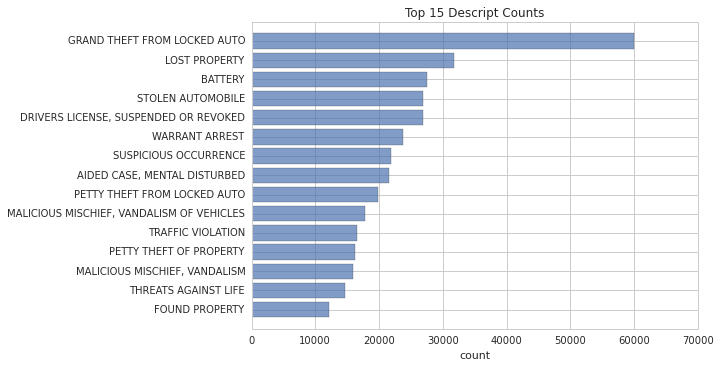

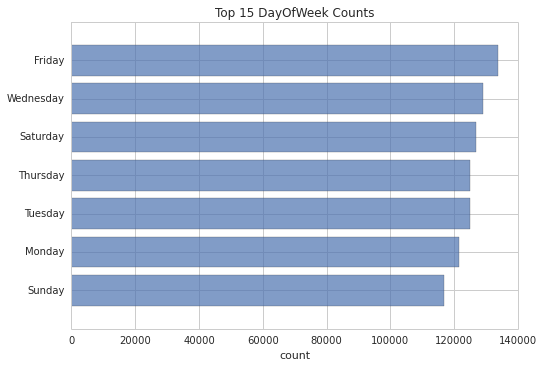

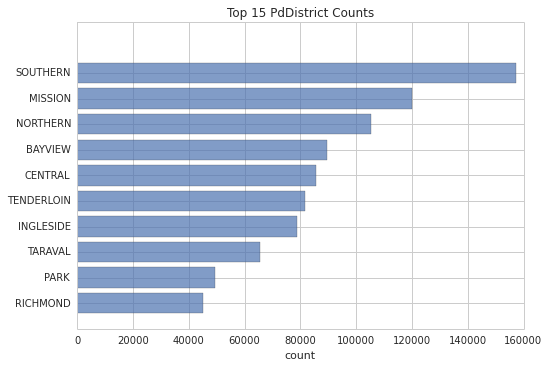

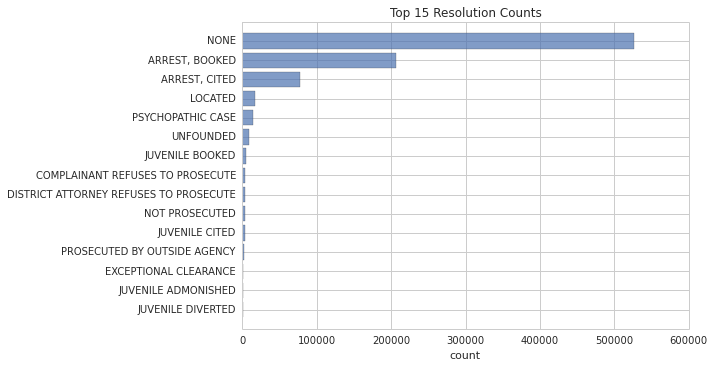

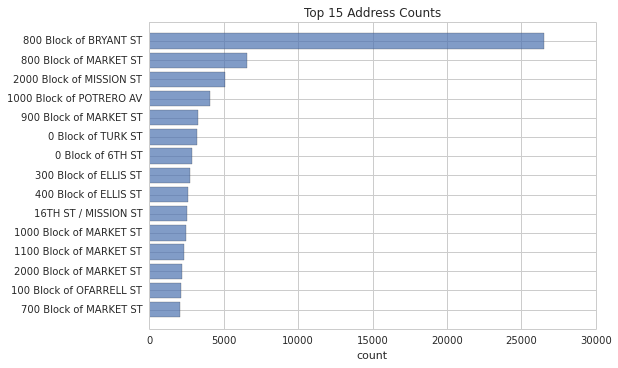

In [283]:
# category.columns
import pandas as pd
cols = [name for name,type in sfc_train.dtypes if type == 'string' ]
for c in cols:
    pdf = sfc_train.groupBy(c).count().orderBy('count', ascending=False).toPandas().head(15)
    
    y_pos = np.arange(start=len(pdf[c]),stop=0,step=-1)

    plt.barh(y_pos, pdf['count'], align='center', alpha=0.7)
    plt.yticks(y_pos, pdf[c])
    plt.xlabel('count')
    plt.title('Top 15 {0} Counts'.format(c))

    plt.show()

In [296]:
from pyspark.sql.functions import *
cols = [name for name,type in sfc_train.dtypes if type == 'string' ] # get a list of all the string columns
summ_cols = ['Column','Null_cnt','Non-null_cnt','Pct_null','Unique_cnt','Max_len','Min_len','Max_words','Min_words']
summ_df = pd.DataFrame(columns=summ_cols)
total_rows = sfc_train.count()
for col in cols:
    sum_vals = []
    print '---- Summarizing: {0} ----'.format(col)
    words = sfc_train.select(split(col," ").alias("l")).map(lambda l: len(l[0]))
    words = words.cache()
    sum_val = [col,
        sfc_train.filter(col+" is Null").count(),       # count of nulls
        sfc_train.filter(col+" is not Null").count(),   # count of non-nulls
        nulls/float(total_rows),                        # pct of nulls
        sfc_train.select(col).distinct().count(),       # count of unique values
        sfc_train.select(max(length(col))).first()[0],  # max length
        sfc_train.select(min(length(col))).first()[0],  # min length
        words.max(),                                    # max number of words
        words.min()]                                    # min number of words
    summ_df.loc[len(summ_df)] = sum_val
    
print summ_df.head(len(summ_df))

---- Summarizing: Category ----
---- Summarizing: Descript ----
---- Summarizing: DayOfWeek ----
---- Summarizing: PdDistrict ----
---- Summarizing: Resolution ----
---- Summarizing: Address ----
       Column  Null_cnt  Non-null_cnt  Pct_null  Unique_cnt  Max_len  Min_len  \
0    Category       0.0      878049.0       0.0        39.0     27.0      4.0   
1    Descript       0.0      878049.0       0.0       879.0     73.0      4.0   
2   DayOfWeek       0.0      878049.0       0.0         7.0      9.0      6.0   
3  PdDistrict       0.0      878049.0       0.0        10.0     10.0      4.0   
4  Resolution       0.0      878049.0       0.0        17.0     38.0      4.0   
5     Address       0.0      878049.0       0.0     23228.0     44.0     11.0   

   Max_words  Min_words  
0        4.0        1.0  
1       11.0        1.0  
2        1.0        1.0  
3        1.0        1.0  
4        5.0        1.0  
5       10.0        3.0  


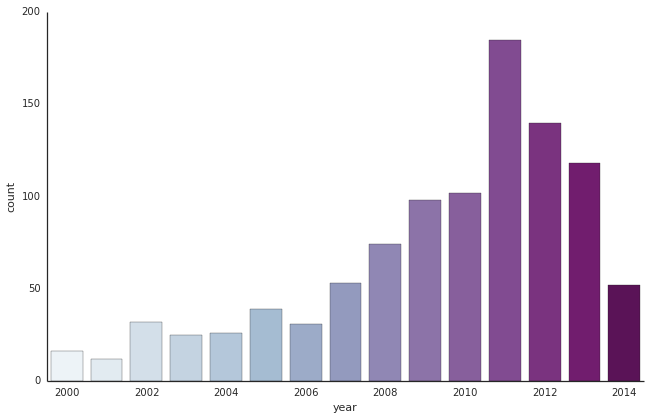

In [45]:
sns.set(style="white")

# Load the example planets dataset
planets = sns.load_dataset("planets")

# Make a range of years to show categories with no observations
years = np.arange(2000, 2015)

# Draw a count plot to show the number of planets discovered each year
g = sns.factorplot(x="year", data=planets, kind="count",
                   palette="BuPu", size=6, aspect=1.5, order=years)
g.set_xticklabels(step=2)

In [49]:
category.columns

Index([u'Category', u'count'], dtype='object')

In [51]:
print len(planets)


1035


In [ ]:
# example 1
g = sns.factorplot(x="age", y="embark_town",
                   hue="sex", row="class",
                   data=titanic[titanic.embark_town.notnull()],
                   orient="h", size=2, aspect=3.5, palette="Set3",
                   kind="violin", split=True, cut=0, bw=.2)

# example 2
g = sns.factorplot(x="who", 
                   y="survived", col="class",
                   data=titanic, saturation=.5,
                   kind="bar", ci=None, aspect=.6)

(g.set_axis_labels("", "Survival Rate")
 .set_xticklabels(["Men", "Women", "Children"])
 .set_titles("{col_name} {col_var}")
 .set(ylim=(0, 1))
 .despine(left=True))

In [56]:
from bokeh.charts import Bar, output_notebook, show
from bokeh.charts.attributes import cat, color
from bokeh.charts.operations import blend
from bokeh.charts.utils import df_from_json
from bokeh.sampledata.olympics2014 import data

# utilize utility to make it easy to get json/dict data converted to a dataframe
df = df_from_json(data)

# filter by countries with at least one medal and sort by total medals
df = df[df['total'] > 0]
df = df.sort("total", ascending=False)

bar = Bar(df,
          values=blend('bronze', 'silver', 'gold', name='medals', labels_name='medal'),
          label=cat(columns='abbr', sort=False),
          stack=cat(columns='medal', sort=False),
          color=color(columns='medal', palette=['SaddleBrown', 'Silver', 'Goldenrod'],
                      sort=False),
          legend='top_right',
          title="Medals per Country, Sorted by Total Medals",
          tooltips=[('medal', '@medal'), ('country', '@abbr')])


# output_file("stacked_bar.html", title="stacked_bar.py example")
output_notebook()

show(bar)

ImportError: No module named bokeh.charts

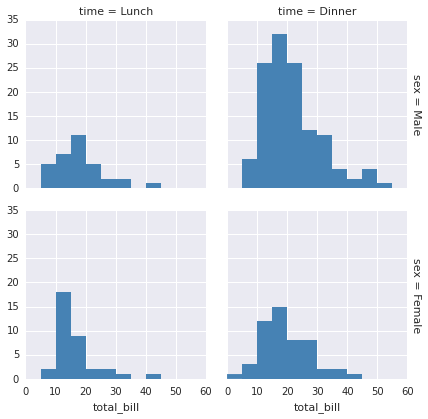

In [141]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

tips = sns.load_dataset("tips")
g = sns.FacetGrid(tips, row="sex", col="time", margin_titles=True)
bins = np.linspace(0, 60, 13)
g.map(plt.hist, "total_bill", color="steelblue", bins=bins, lw=0)


In [297]:
sc.stop()